# Only GenomeViz Plots

antman environment

In [3]:
from pygenomeviz import GenomeViz
import Bio.SeqIO as SeqIO
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import sys
sys.path.append('../')
from transcriptomics import * 
from plotting import * 
from hcr import * 

Initializing transcriptomics package
Initializing plotting package
Initializing HCR package


In [4]:
# Load genome
genome_fasta_path = '../raw-data/OBir/genome/Obir.assembly.v5.4.fasta'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [5]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [6]:
object_name = "../raw-data/OBir/transcriptome/biroi_transcriptome"
tr = load_transcriptome_object(object_name)

In [7]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'n_exons'] = len(transcript.exons)
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db.groupby('tandem_array')['start'].rank(method='first', ascending=True).astype(int)

or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,8.0,False,2,1
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,7.0,False,2,2
2,1,Or5-Orco,72,3,NaN,10910490,10919026,+,Chr1,9.0,False,2,1
3,1,Or5-Q2,72,4,NaN,10934666,10938750,+,Chr1,6.0,False,2,2
4,1,Or5-9E1,73,5,NaN,10980671,10984094,+,Chr1,6.0,True,1,1


In [8]:
# Sum of nine_exon 
or_db['nine_exon'].sum()

316

In [9]:
tandem_array = 3 
rows = or_db.loc[or_db.tandem_array == tandem_array]
rows = rows.sort_values(by='start').reset_index(drop=True)
print(f"Number of ORs in TA{tandem_array}: {rows.shape[0]}")
start = rows.start.min() - 100 
end = rows.end.max() + 100
chromosome = rows.chr.iloc[0]
print(f"{chromosome}, Start: {start}, End: {end}")

Number of ORs in TA3: 32
Chr12, Start: 8696405, End: 8810816


In [10]:
location="Chr12:8,730,000-8,760,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

Chr: <built-in function chr>, Start: 8730000, End: 8760000


In [11]:
genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 

## T79

Chr: <built-in function chr>, Start: 17883600, End: 17944020


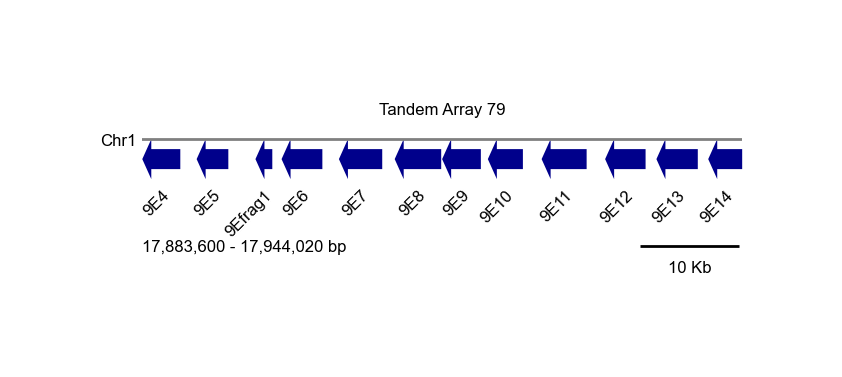

In [12]:
location="Chr1:17883600-17944020"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']


gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.8, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1.5)
import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        color = 'purple'
        rotation = 0
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'darkblue'
        rotation = 45 
        label = gene
    else: 
        color = 'grey'
        rotation = 45
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "right"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)

plt.title("Tandem Array 79", fontsize=6, color='black', y=0.6)
gv.savefig(f"../figures/t79-locus.pdf", pad_inches=0, dpi=200)

plt.show()


## Chymotrypsin Figure

Chr: <built-in function chr>, Start: 4950000, End: 5030000


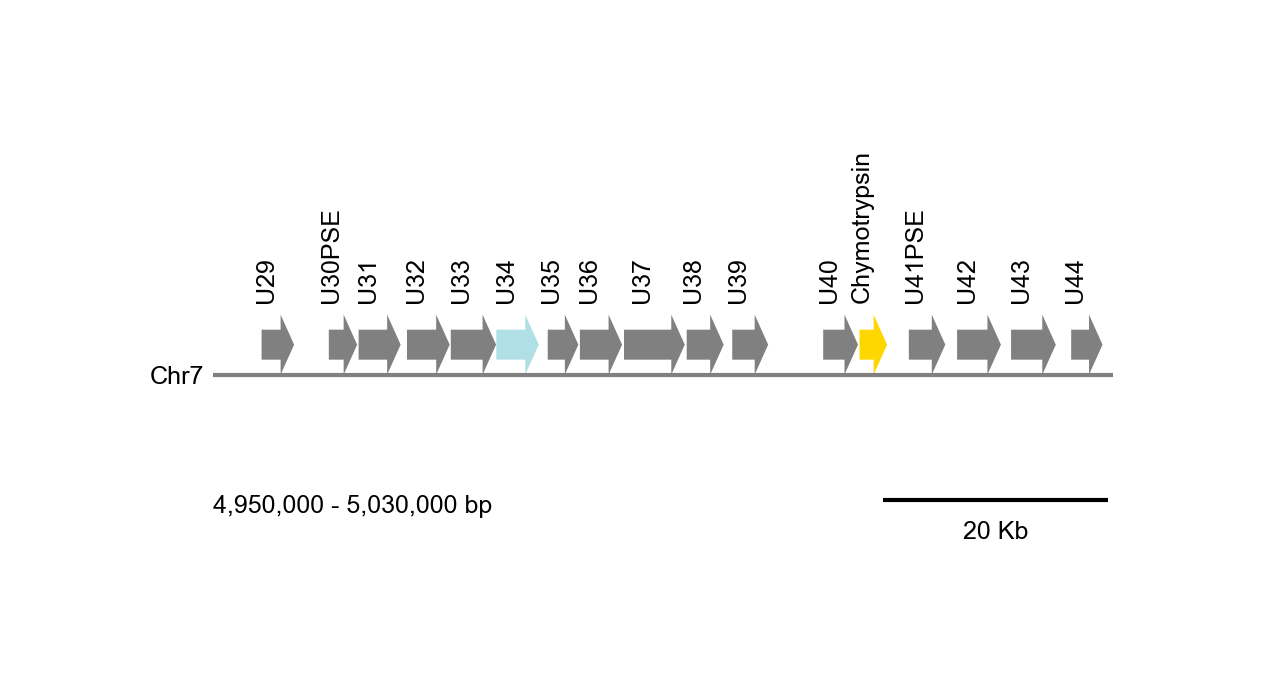

In [13]:
location="Chr7:4,950_000-5,030_000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
        color = 'grey'
        rotation = 0
        label = f"{gene} (lncRNA)"
    elif "LOC105276652" in gene:
        color = 'gold'
        rotation = 90
        label = f"Chymotrypsin"
    elif "U34" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'powderblue'
        rotation = 90
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 90 
        label = gene
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "center"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=300)
gv.savefig(f"../figures/chymotrypsin-locus.pdf", pad_inches=0, dpi=300)

plt.show()



In [14]:
# Distance from LOC105276652 to U34 
tr.get_gene('LOC105276652').get_transcript_longest_cds().get_bounds()[0] - tr.get_gene('Or5-U34').get_transcript_longest_cds().get_bounds()[1]

28508

## T51 Figure

In [15]:
or_db.loc[or_db.tandem_array == 51]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
105,3,Or5-9E89,51,106,3',4121622,4124905,-,Chr3,9.0,True,16,1
106,3,Or5-9E90,51,107,NaN,4126000,4129001,-,Chr3,9.0,True,16,2
107,3,Or5-9E91,51,108,5',4129885,4133249,-,Chr3,9.0,True,16,3
108,3,Or5-9E92,51,109,5',4131332,4137756,+,Chr3,9.0,True,16,4
109,3,Or5-9E93,51,110,NaN,4137991,4141727,+,Chr3,9.0,True,16,5
110,3,Or5-9E94,51,111,NaN,4143160,4146673,+,Chr3,9.0,True,16,6
111,3,Or5-9E95,51,112,NaN,4147691,4150197,+,Chr3,9.0,True,16,7
112,3,Or5-9E96,51,113,NaN,4151300,4154109,+,Chr3,9.0,True,16,8
113,3,Or5-9E97,51,114,NaN,4155017,4157855,+,Chr3,9.0,True,16,9
114,3,Or5-9E98,51,115,NaN,4158776,4161384,+,Chr3,9.0,True,16,10


Chr: <built-in function chr>, Start: 4120000, End: 4185000


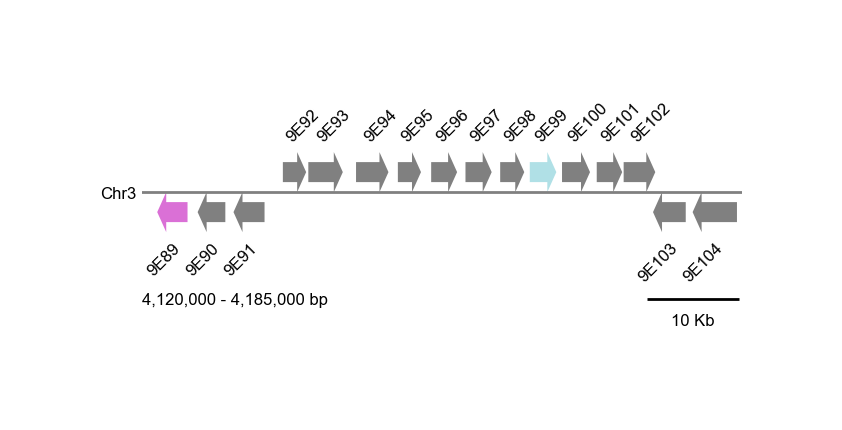

In [16]:
location="Chr3:4,120,000-4,185,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.8, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1.5)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
    elif "9E89" in gene:
        color = 'orchid'
    elif "9E99" in gene:
        color = 'powderblue'
    elif "Or5" in gene: 
        color = 'grey'
    else: 
        color = 'grey'
    
    label = re.sub(r'Or5-', '', gene)
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom" 
    hpos = "left" if strand == 1 else "right"
    rotation = 45
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t51-9e89-9e99-locus.pdf", pad_inches=0, dpi=200)

plt.show()



In [17]:
# Distance from LOC105276652 to U34 
tr.get_gene('Or5-9E99').get_transcript_longest_cds().get_bounds()[0] - tr.get_gene('Or5-9E89').get_transcript_longest_cds().get_bounds()[1]

37077

Chr: <built-in function chr>, Start: 4130000, End: 4220000


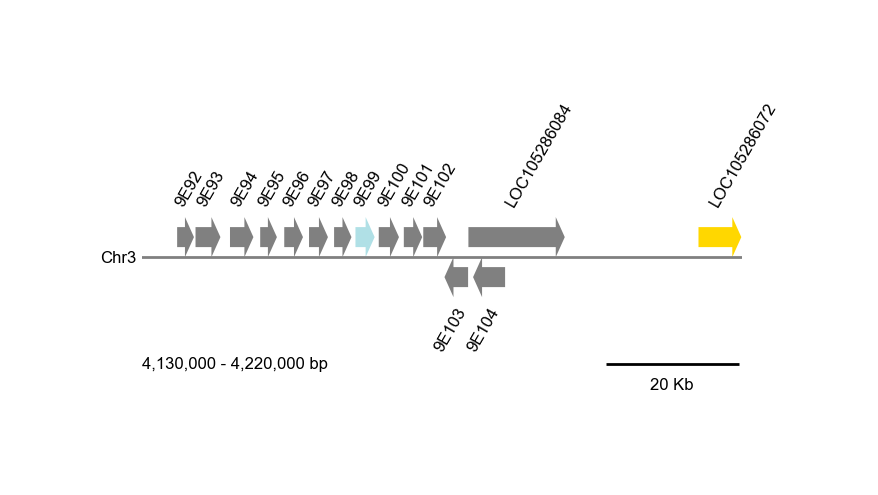

In [18]:
location="Chr3:4,130,000-4,220,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.8, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1.5)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
    elif "9E99" in gene:
        color = 'powderblue'
    elif "LOC105286072" in gene:
        color = 'gold'
    elif "Or5" in gene: 
        color = 'grey'
    else: 
        color = 'grey'
    
    label = re.sub(r'Or5-', '', gene)
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom" 
    hpos = "left" if strand == 1 else "right"
    rotation = 60
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t51-9e99-downstream-locus.pdf", pad_inches=0, dpi=200)

plt.show()



In [19]:
# Distance from LOC105276652 to U34 
tr.get_gene('LOC105286072').get_transcript_longest_cds().get_bounds()[0] - tr.get_gene('Or5-9E99').get_transcript_longest_cds().get_bounds()[1]

48579

## T45 Figure

In [20]:
or_db.loc[or_db.tandem_array == 45].sort_values(by='start').reset_index(drop=True)

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
0,4,Or5-9E107,45,152,3',10512095,10519055,-,Chr4,13.0,True,22,1
1,4,Or5-9E108,45,153,NaN,10519831,10528999,-,Chr4,16.0,True,22,2
2,4,Or5-9E109,45,154,NaN,10529046,10534871,-,Chr4,9.0,True,22,3
3,4,Or5-9E110,45,155,NaN,10535533,10542800,-,Chr4,9.0,True,22,4
4,4,Or5-9E111,45,156,NaN,10544839,10552158,-,Chr4,11.0,True,22,5
5,4,Or5-9E112,45,157,NaN,10553253,10557373,-,Chr4,9.0,True,22,6
6,4,Or5-9E113,45,158,NaN,10558214,10565613,-,Chr4,11.0,True,22,7
7,4,Or5-9E114,45,159,NaN,10567887,10576136,-,Chr4,10.0,True,22,8
8,4,Or5-9E115,45,160,NaN,10577099,10582481,-,Chr4,11.0,True,22,9
9,4,Or5-9E116,45,161,NaN,10584348,10588744,-,Chr4,11.0,True,22,10


In [21]:
print(f"T45 contains {or_db.loc[or_db.tandem_array == 45].shape[0]} ORs")

T45 contains 22 ORs


Chr: <built-in function chr>, Start: 10503000, End: 10700000


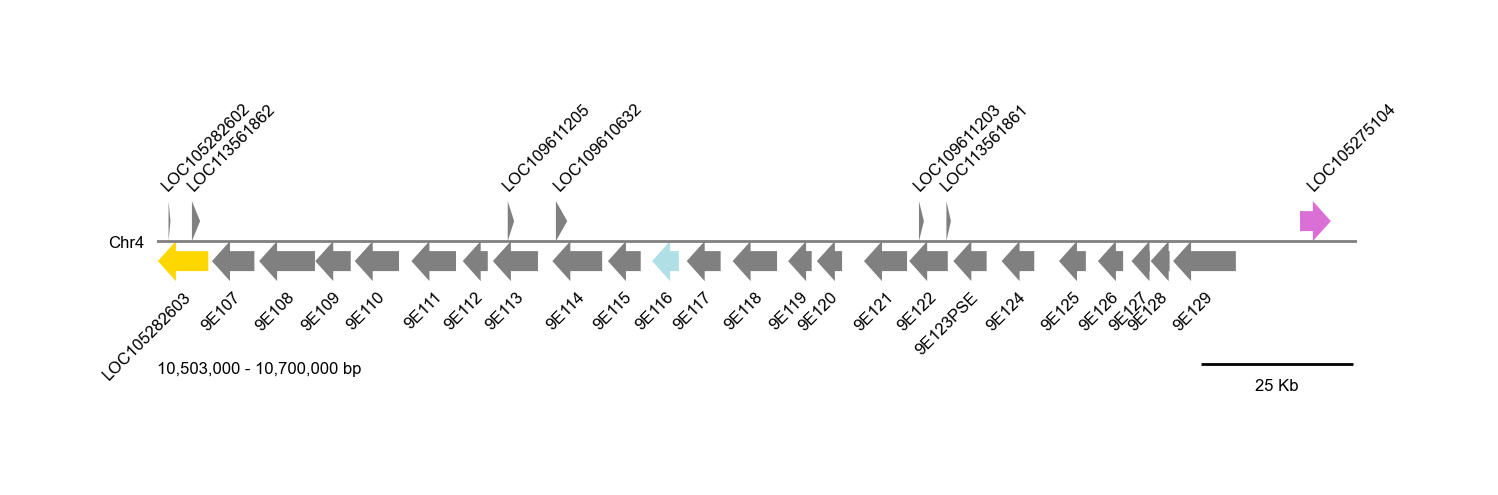

In [22]:
location="Chr4:10,503,000-10,700,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=6, fig_track_height=0.4)
gv.set_scale_bar(ymargin=1, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=2)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        color = 'grey'
        rotation = 45
        label = gene
    elif "LOC105275104" in gene:
        color = 'orchid'
        rotation = 45
        label = f"LOC105275104"
    elif "LOC105282603" in gene: 
        color = 'gold' 
        rotation = 45 
        label = f"LOC105282603"
    elif "9E116" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'powderblue'
        rotation = 45
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 45 
        label = gene
    else: 
        color = 'grey'
        rotation = 45
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "right"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': 45, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t45-upstream-and-downstream-locus.pdf", pad_inches=0, dpi=200)

plt.show()



Chr: <built-in function chr>, Start: 10510000, End: 10700000


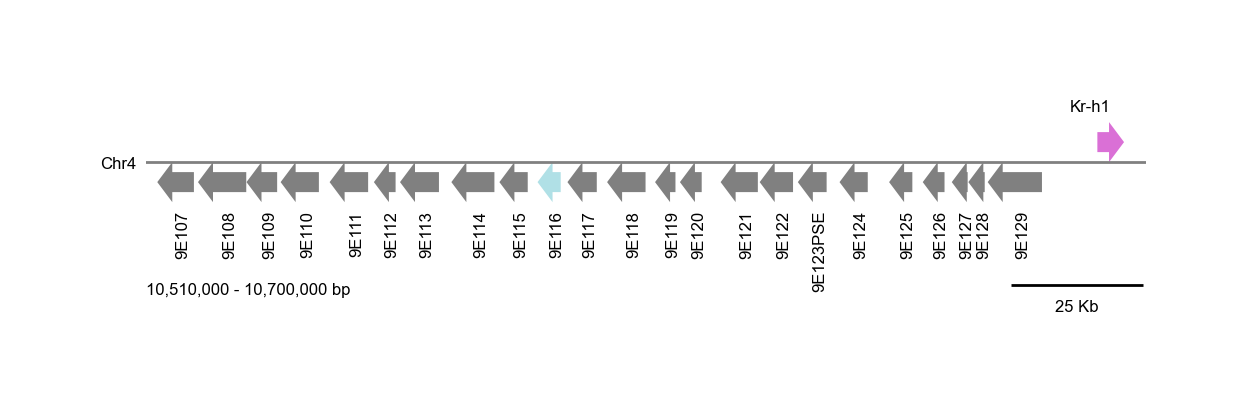

In [23]:
location="Chr4:10,510,000-10,700,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=5, fig_track_height=0.4)
gv.set_scale_bar(ymargin=1, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=2)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
    elif "LOC105275104" in gene:
        color = 'orchid'
        rotation = 0
        label = "Kr-h1" 
    elif "LOC109610632" in gene: 
        continue
    elif "9E116" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'powderblue'
        rotation = 90
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 90 
        label = gene
    else: 
        color = 'grey'
        rotation = 45
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "right" if strand == 1 else "right"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t45-9E116-LOC105275104-locus.pdf", pad_inches=0, dpi=200)

plt.show()



Chr: <built-in function chr>, Start: 10503000, End: 10600000


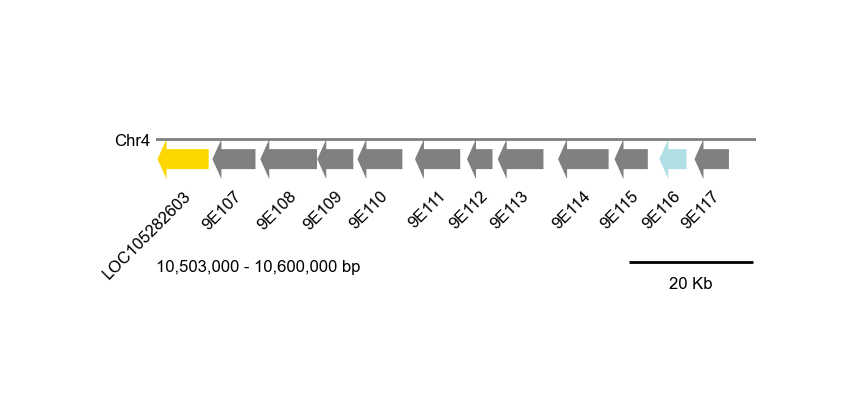

In [24]:
location="Chr4:10,503,000-10,600,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=1, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=2)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
    elif "LOC105282603" in gene:
        color = 'gold'
        label = gene 
    elif "LOC109610632" in gene: 
        continue
    elif "9E116" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'powderblue'
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        label = gene
    else: 
        color = 'grey'
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "right" if strand == 1 else "right"
    rotation = 45 
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        lw=0,
        ec='black', 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )



fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t45-9E116-LOC105282603-locus.pdf", pad_inches=0, dpi=200)

plt.show()



In [25]:
# Distance from 9E116 to LOC105275104
print(f"Distance from 9E116 to LOC105275104: {abs(tr.get_gene('Or5-9E116').get_transcript_longest_bounds().get_bounds()[0] - tr.get_gene('LOC105275104').get_transcript_longest_bounds().get_bounds()[0])}")

Distance from 9E116 to LOC105275104: 106365


## T19 Figure

In [26]:
or_db.loc[or_db.tandem_array == 19].shape

(55, 13)

Chr: <built-in function chr>, Start: 4900000, End: 4987000


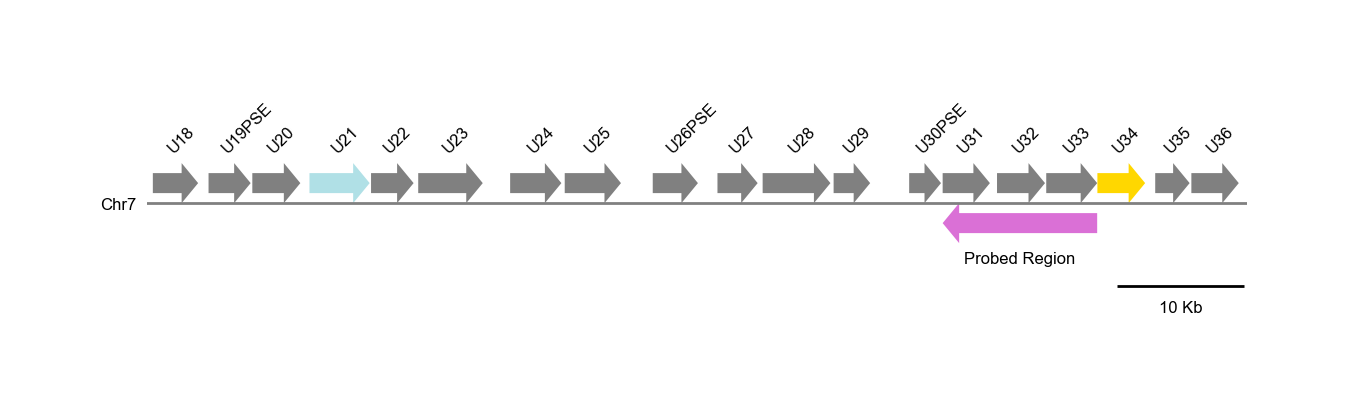

In [27]:
location="Chr7:4,900,000-4,987,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    if len(gene_obj.transcripts) == 0:
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=5.5, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
#track.add_sublabel(size=6, ymargin=1)


import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if "256" in gene: 
        continue
    elif "U21" in gene:
        color = 'powderblue'
        rotation = 45
        label = re.sub(r'Or5-', '', gene)
    elif "U34" in gene:
        color = 'gold'
        rotation = 45
        label = re.sub(r'Or5-', '', gene)
    elif "Or5" in gene: 
        color = 'grey'
        rotation = 45 
        label = re.sub(r'Or5-', '', gene)
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "center"
    if bounds[0] < start or bounds[1] > end: 
        continue
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        ec='black',
        lw=0,
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )

# Chr12:8737905-8745171
track.add_feature(int(4962909), 
                  int(4975130), 
                  strand=-1, 
                  plotstyle='arrow', 
                  fc='orchid', 
                  lw=0,
                  ec='black', 
                  label='Probed Region', 
                  text_kws={'color': 'black', 
                            'rotation': 0, 
                            'vpos': 'bottom', 
                            'hpos': 'center', 
                            'size':6
                            }
)

fig = gv.plotfig(dpi=200)

gv.savefig(f"../figures/t19-lncrna-locus.pdf", pad_inches=0, dpi=200)

plt.show()

In [28]:
# Assess distance of PR to U34 
pr_start, pr_end = 4962909, 4975130
u34_start = or_db.loc[or_db.gene_name == 'Or5-U34'].start.values[0]
print(f"Distance between U34 and PR: {u34_start - pr_end} to {u34_start - pr_start}")

Distance between U34 and PR: 18 to 12239


## L16 Lnc2 Lnc3 Figure

Chr: <built-in function chr>, Start: 8700000, End: 8765000


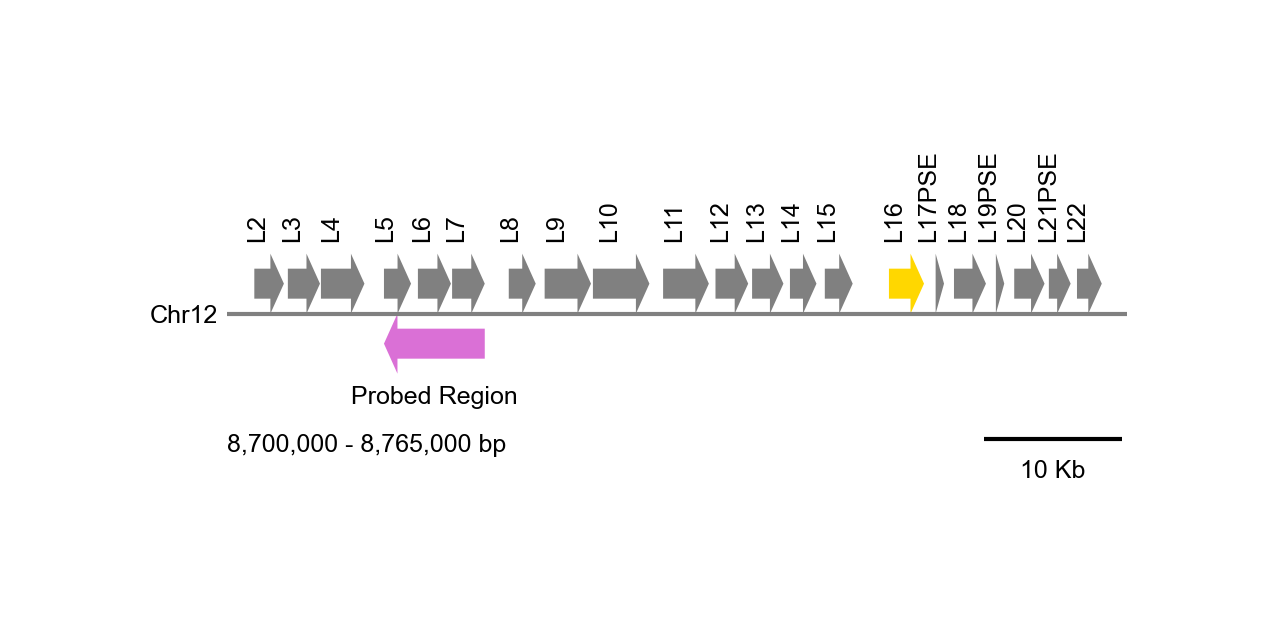

In [29]:
location="Chr12:8,700,000-8,765,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    if "874" in gene: 
        continue
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        color = 'grey'
        rotation = 0
        label = gene
    elif "L16" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'gold'
        rotation = 90
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 90 
        label = gene
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "center"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        ec='black', 
        lw=0, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )


# Chr12:8711318-8718598
track.add_feature(int(8711318), 
                  int(8718598), 
                  strand=-1, 
                  plotstyle='arrow', 
                  fc='orchid', 
                  label='Probed Region', 
                  lw=0,
                  ec='black', 
                  text_kws={'color': 'black', 
                            'rotation': 0, 
                            'vpos': 'bottom', 
                            'hpos': 'center', 
                            'size':6
                            }
)


fig = gv.plotfig(dpi=300)
gv.savefig(f"../figures/T3-one-lnc-locus.pdf", pad_inches=0, dpi=200)
plt.show()

In [30]:
# Probed Region 1: 
pr1_start, pr1_end = 8737905, 8745171
# Probed Region 2:
pr2_start, pr2_end = 8711318, 8718598
# L16 
l16_start = or_db.loc[or_db.gene_name == 'Or5-L16'].start.values[0]

# Distance from L16 to Probed Region 1
print(f"Distance from L16 to Probed Region 1: {l16_start - pr1_start} to {l16_start - pr1_end}")
# Distance from L16 to Probed Region 2
print(f"Distance from L16 to Probed Region 2: {l16_start - pr2_start} to {l16_start - pr2_end}")

Distance from L16 to Probed Region 1: 9884 to 2618
Distance from L16 to Probed Region 2: 36471 to 29191


In [31]:
or_db.loc[or_db.tandem_array == 3].shape

(32, 13)

## Q1 R2 Figure

In [32]:
or_db.loc[or_db.tandem_array == 70]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',6504395,6510987,-,Chr1,8.0,False,2,1
1,1,Or5-Q1,70,2,5',6511625,6514800,-,Chr1,7.0,False,2,2


Chr: <built-in function chr>, Start: 6498000, End: 6518000


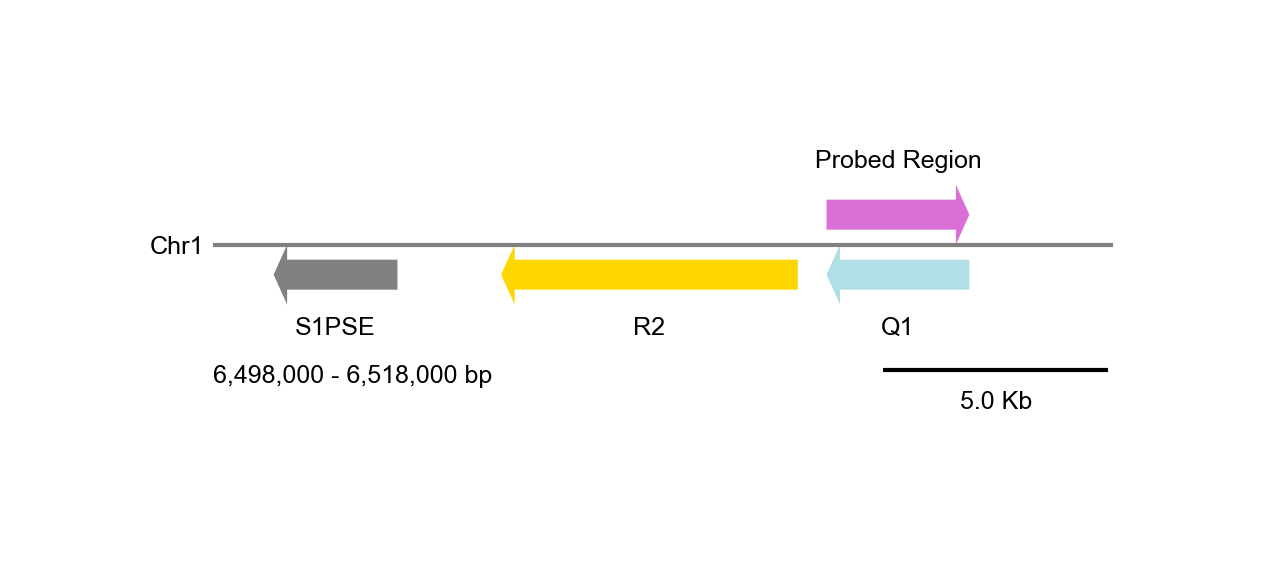

In [33]:
location="Chr1:6,498,000-6,518,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=3, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)

import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        color = 'grey'
        rotation = 0
        label = gene
    elif "R2" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'gold'
        rotation = 0
        label = gene
    elif "Q1" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'powderblue'
        rotation = 0
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 0 
        label = gene
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "center"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        ec='black', 
        lw=0, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )

# Chr12:8737905-8745171
track.add_feature(int(6511625), 
                  int(6514800), 
                  strand=1, 
                  plotstyle='arrow', 
                  fc='orchid', 
                  label='Probed Region', 
                  lw=0,
                  ec='black', 
                  text_kws={'color': 'black', 
                            'rotation': 0, 
                            'vpos': 'top', 
                            'hpos': 'center', 
                            'size':6
                            }
)


fig = gv.plotfig(dpi=300)
gv.savefig(f"../figures/q1-r2-pr-locus.pdf", pad_inches=0, dpi=200)
plt.show()

In [34]:
or_db.loc[or_db.gene_name == "Or5-R3"]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
331,8,Or5-R3,88,332,NaN,399544,406595,-,Chr8,8.0,False,1,1


## G1 Singleton Figure

In [35]:
or_db.loc[or_db.gene_name=="Or5-G1"]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
198,6,Or5-G1,28,199,NaN,7360061,7493471,-,Chr6,6.0,False,1,1


In [36]:
# find the closest ORs to G1 on either side 
or_db = or_db.sort_values(by=['chr', 'start']).reset_index(drop=True)
g1_index = or_db.loc[or_db.gene_name=="Or5-G1"].index[0]
or_db.loc[g1_index-1:g1_index+1]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
346,6,Or5-9E155,27,198,NaN,7312765,7316471,+,Chr6,8.0,True,1,1
347,6,Or5-G1,28,199,NaN,7360061,7493471,-,Chr6,6.0,False,1,1
348,6,Or5-9E156,29,200,NaN,7644182,7651906,-,Chr6,9.0,True,1,1


In [37]:
# distance from G1 to 9E156
g1_start = or_db.loc[or_db.gene_name=="Or5-G1"].start.values[0]
e156_start = or_db.loc[or_db.gene_name=="Or5-9E156"].start.values[0]
e155_start = or_db.loc[or_db.gene_name=="Or5-9E155"].start.values[0]
print(f"Distance from G1 to 9E156: {e156_start - g1_start}")
print(f"Distance from G1 to 9E155: {g1_start - e155_start}")


Distance from G1 to 9E156: 284121
Distance from G1 to 9E155: 47296


In [38]:
# H subfamily 
or_db.loc[or_db.gene_name.str.contains("H")]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
20,1,Or5-H1,80,21,3',18401037,18404290,-,Chr1,7.0,False,4,1
22,1,Or5-H2,80,23,NaN,18410663,18414867,-,Chr1,9.0,False,4,3
23,1,Or5-H3,80,24,5',18419184,18422446,-,Chr1,6.0,False,4,4
479,7,Or5-H5,21,331,NaN,16393872,16396588,+,Chr7,7.0,False,1,1


In [39]:
tr.get_gene("LOC113562161").get_transcript_longest_cds().get_bounds()

[7493727, 7504256]

In [40]:
tr.get_gene("LOC113562161").gene_biotype

'lncRNA'

Chr: <built-in function chr>, Start: 7350000, End: 7505000


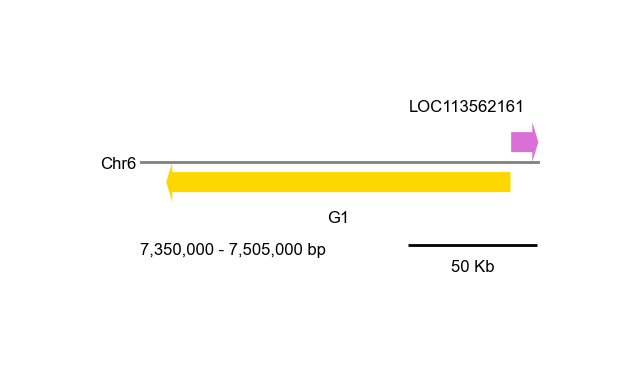

In [41]:
location="Chr6:7,350,000-7,505,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

# remove LOC...2160 from genes_to_plot
genes_to_plot = [gene for gene in genes_to_plot if "LOC113562160" not in gene]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=2, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.5, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=1)


import re 


# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).gene_biotype == 'lncRNA': 
        color = 'orchid'
        rotation = 0
        label = gene
    elif "G1" in gene:
        gene = re.sub(r'Or5-', '', gene)
        color = 'gold'
        rotation = 0
        label = gene
    elif "Or5" in gene: 
        gene = re.sub(r'Or5-', '', gene)
        color = 'grey'
        rotation = 45 
        label = f"{gene} (OR)"
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "right" if strand == 1 else "center"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        ec='black',
        lw=0,
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )


fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/g1-lnc-locus.pdf", pad_inches=0, dpi=200)
plt.show()

In [42]:
genes_to_plot

['LOC113562161', 'Or5-G1']

## T35 Figure

In [43]:
or_db.loc[or_db.gene_name=="Or5-9E198"]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
387,6,Or5-9E198,35,239,5'-3',10618926,10624403,+,Chr6,8.0,True,16,14


Chr: <built-in function chr>, Start: 10570000, End: 10660000


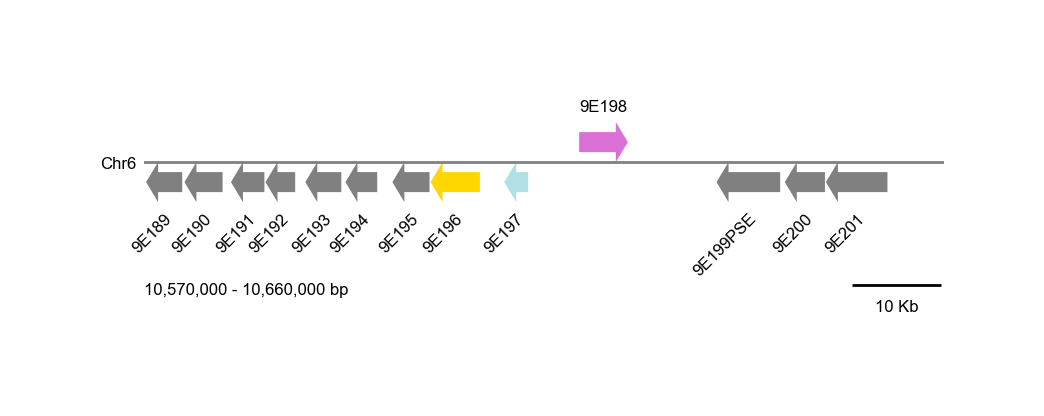

In [44]:
location="Chr6:10,570,000-10,660,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
gv = GenomeViz(track_align_type="center", theme="light", fig_width=4, fig_track_height=0.4)
gv.set_scale_bar(ymargin=1, labelsize=6)

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
track.add_sublabel(size=6, ymargin=2)

import re

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        color = 'powderblue'
        rotation = 0
        label = f"{gene} (lncRNA)"
    elif "9E198" in gene:
        color = 'orchid'
        rotation = 0
        label = f"{re.sub("Or5-", "", gene)}"
    elif "9E197" in gene:
        color = 'powderblue'
        rotation = 45
        label = f"{re.sub("Or5-", "", gene)}"
    elif "9E196" in gene:
        color = 'gold'
        rotation = 45
        label = f"{re.sub("Or5-", "", gene)}"
    elif "Or5" in gene: 
        color = 'grey'
        rotation = 45 
        label = f"{re.sub("Or5-", "", gene)}"
    else: 
        color = 'grey'
        rotation = 45
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "center" if strand == 1 else "right"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        ec='black',
        lw=0,
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )


fig = gv.plotfig(dpi=200)
gv.savefig(f"../figures/t35-locus.pdf", pad_inches=0, dpi=200)
plt.show()

## 9E88 Lnc Figure

In [45]:
or_db.loc[or_db.gene_name == "Or5-9E88"]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
253,3,Or5-9E88,50,105,NaN,3987004,3991057,+,Chr3,8.0,True,1,1


Chr: <built-in function chr>, Start: 3982000, End: 3992000


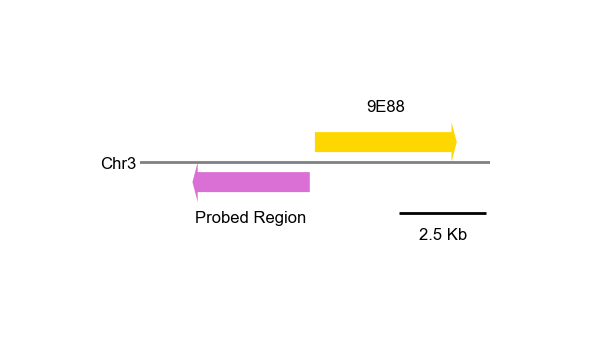

In [73]:
location="Chr3:3,982,000-3,992,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    if len(gene_obj.transcripts) == 0:
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=1.75, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.1, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
#track.add_sublabel(size=6, ymargin=1)


import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if "256" in gene: 
        continue
    elif "9E88" in gene:
        color = 'gold'
        rotation = 0
        label = re.sub(r'Or5-', '', gene)
    else: 
        color = 'grey'
        rotation = 0
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "center" if strand == 1 else "center"
    if bounds[0] < start or bounds[1] > end: 
        continue
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        ec='black',
        lw=0,
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )

# Chr12:8737905-8745171
track.add_feature(int(3983506), 
                  int(3986858), 
                  strand=-1, 
                  plotstyle='arrow', 
                  fc='orchid', 
                  lw=0,
                  ec='black', 
                  label='Probed Region', 
                  text_kws={'color': 'black', 
                            'rotation': 0, 
                            'vpos': 'bottom', 
                            'hpos': 'center', 
                            'size':6
                            }
)

fig = gv.plotfig(dpi=200)

gv.savefig(f"../figures/lncrna-9e88-locus.pdf", pad_inches=0, dpi=200)

plt.show()

## U54 and 100kbp Lnc Figure

In [74]:
or_db.loc[or_db.gene_name == "Or5-U54"]

,chromosome,gene_name,tandem_array,rank,orientation,start,end,strand,chr,n_exons,nine_exon,ta_size,ta_index
465,7,Or5-U54,19,317,NaN,5078907,5082567,+,Chr7,7.0,False,55,44


Chr: <built-in function chr>, Start: 4950000, End: 5100000


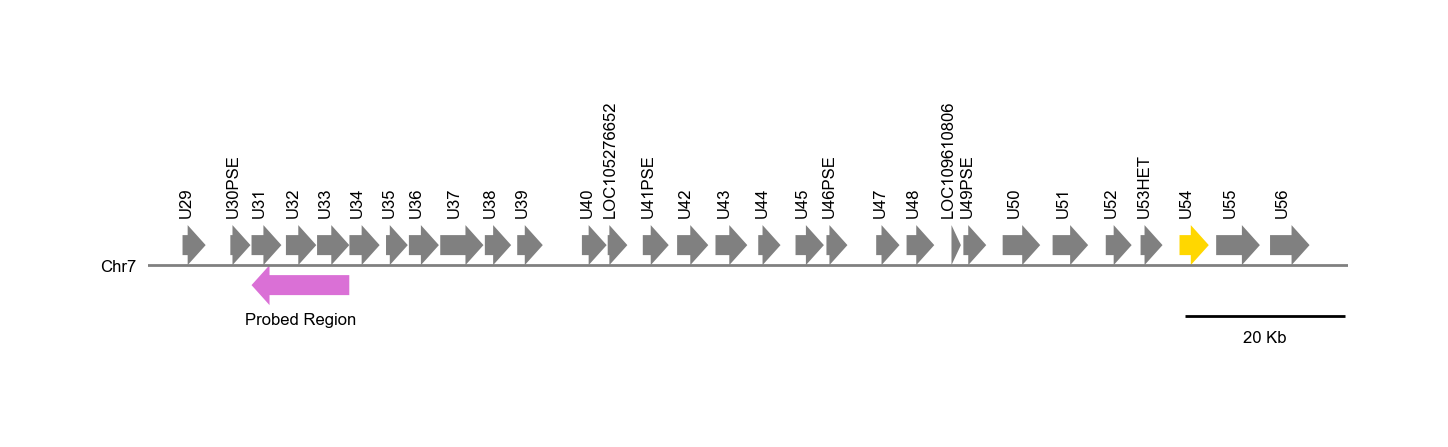

In [82]:
location="Chr7:4,950,000-5,100,000"
chromosome=location.split(":")[0]
start=int(location.split(":")[1].split("-")[0].replace(",",""))
end=int(location.split(":")[1].split("-")[1].replace(",",""))
print(f'Chr: {chr}, Start: {start}, End: {end}')

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    if len(gene_obj.transcripts) == 0:
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 
# Make a plot of lncRNAs in a particular TA 

gene_bounds = [tr.get_gene(gene).get_transcript_longest_cds().get_bounds() for gene in genes_to_plot]

white_plotting()

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

gv = GenomeViz(track_align_type="center", theme="light", fig_width=6, fig_track_height=0.4)
gv.set_scale_bar(ymargin=0.1, labelsize=6)

track = gv.add_feature_track(chromosome, segments = (int(start), int(end)), labelsize=6)
#track.add_sublabel(size=6, ymargin=1)


import re 

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_cds()
    if tr.get_gene(gene).transcript_biotype == 'lnc_RNA': 
        continue
    elif "256" in gene: 
        continue
    elif "U54" in gene:
        color = 'gold'
        rotation = 90
        label = re.sub(r'Or5-', '', gene)
    else: 
        color = 'grey'
        rotation = 90
        label = re.sub(r'Or5-', '', gene)
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    hpos = "left" if strand == 1 else "center"
    if bounds[0] < start or bounds[1] > end: 
        continue
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        ec='black',
        lw=0,
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': rotation, 
                  'vpos': vpos, 
                  'hpos': hpos, 
                  'size':6}
    )

# Chr12:8737905-8745171
track.add_feature(int(4962909), 
                  int(4975130), 
                  strand=-1, 
                  plotstyle='arrow', 
                  fc='orchid', 
                  lw=0,
                  ec='black', 
                  label='Probed Region', 
                  text_kws={'color': 'black', 
                            'rotation': 0, 
                            'vpos': 'bottom', 
                            'hpos': 'center', 
                            'size':6
                            }
)

fig = gv.plotfig(dpi=200)

gv.savefig(f"../figures/U54-lncRNA-U31-33-locus.pdf", pad_inches=0, dpi=200)

plt.show()